In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import catboost as cat
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar
from dateutil.easter import easter
from datetime import timedelta
import lightgbm as lgb
import optuna
import warnings
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFECV

warnings.filterwarnings("ignore")


color_pal = sns.color_palette()

In [2]:
data = pd.read_parquet(Path("data") / "train.parquet")
test_data = pd.read_parquet(Path("data") / "test.parquet")
data["date"] = pd.to_datetime(data["date"])
data = data.set_index("date")
test_data["date"] = pd.to_datetime(test_data["date"])
test_data = test_data.set_index("date")

In [3]:
prediction_data = pd.read_parquet(Path("data") / "final_test.parquet")

In [4]:
prediction_data["date"] = pd.to_datetime(prediction_data["date"])
prediction_data = prediction_data.set_index("date")

In [5]:
class FrenchHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("New Year's Day", month=1, day=1),
        Holiday("Labour Day", month=5, day=1),
        Holiday("Victory in Europe Day", month=5, day=8),
        Holiday("Bastille Day", month=7, day=14),
        Holiday("Assumption of Mary", month=8, day=15),
        Holiday("All Saints' Day", month=11, day=1),
        Holiday("Armistice Day", month=11, day=11),
        Holiday("Christmas Day", month=12, day=25),
    ]

    @staticmethod
    def easter_related_holidays(year):
        easter_sunday = easter(year)
        return [
            (easter_sunday + timedelta(days=1), "Easter Monday"),
            (easter_sunday + timedelta(days=39), "Ascension Day"),
        ]

In [6]:
def cyclical_encode(df, column, max_value):
    df[column + "_sin"] = np.sin(2 * np.pi * df[column] / max_value)
    df[column + "_cos"] = np.cos(2 * np.pi * df[column] / max_value)
    return df

In [7]:
def create_features(df):
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["dayofyear"] = df.index.dayofyear

    # Boolean for weekends
    df["is_weekend"] = df["dayofweek"].isin([5, 6])

    # cyclical
    df = cyclical_encode(df, "hour", 24)
    df = cyclical_encode(df, "dayofweek", 7)

    # Boolean for holidays
    cal = FrenchHolidayCalendar()
    holidays = cal.holidays(start=df.index.min(), end=df.index.max())
    easter_holidays = []
    for year in range(df.index.year.min(), df.index.year.max() + 1):
        for date, _ in FrenchHolidayCalendar.easter_related_holidays(year):
            easter_holidays.append(date)
    holidays = holidays.union(pd.to_datetime(easter_holidays))
    df["is_holiday"] = df.index.isin(holidays)

    # Lockdown periods
    lockdowns = {
        "lockdown_1": ("2020-03-17", "2020-05-10"),
        "lockdown_2": ("2020-10-28", "2020-12-01"),
        # with curfew from 7 PM to 6 AM
        "lockdown_3_1": ("2021-04-03", "2021-05-18"),
        # with curfew from 9 PM to 6 AM
        "lockdown_3_2": ("2021-05-19", "2021-06-08"),
        # with curfew from 11 PM to 6 AM
        "lockdown_3_3": ("2021-06-09", "2021-06-29"),
    }
    for lockdown, (start_date, end_date) in lockdowns.items():
        mask = (df.index >= start_date) & (df.index <= end_date)
        df[lockdown] = mask

    return df

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 455163 entries, 2020-09-01 02:00:00 to 2021-08-09 17:00:00
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   counter_installation_date  455163 non-null  datetime64[ns]
 6   counter_technical_id       455163 non-null  category      
 7   latitude                   455163 non-null  float64       
 8   longitude                  455163 non-null  float64       
 9   log_bike_count             455163 non-null  float64       
dtypes: category(4), datetime64[ns](1), float64(4), int64(1)
memory usage: 26.1 MB


In [9]:
train = data[["counter_name", "log_bike_count"]]
test = test_data[["counter_name", "log_bike_count"]]
prediction = prediction_data[["counter_name"]]

In [10]:
train = create_features(train)

In [11]:
test = create_features(test)

In [12]:
prediction = create_features(prediction)

In [13]:
prediction.head()

,counter_name,hour,dayofweek,quarter,month,dayofyear,is_weekend,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,is_holiday,lockdown_1,lockdown_2,lockdown_3_1,lockdown_3_2,lockdown_3_3
date,,,,,,,,,,,,,,,,,
2021-09-10 01:00:00,28 boulevard Diderot E-O,1,4,3,9,253,False,0.258819,0.965926,-0.433884,-0.900969,False,False,False,False,False,False
2021-09-10 13:00:00,28 boulevard Diderot E-O,13,4,3,9,253,False,-0.258819,-0.965926,-0.433884,-0.900969,False,False,False,False,False,False
2021-09-10 17:00:00,28 boulevard Diderot E-O,17,4,3,9,253,False,-0.965926,-0.258819,-0.433884,-0.900969,False,False,False,False,False,False
2021-09-10 19:00:00,28 boulevard Diderot E-O,19,4,3,9,253,False,-0.965926,0.258819,-0.433884,-0.900969,False,False,False,False,False,False
2021-09-10 22:00:00,28 boulevard Diderot E-O,22,4,3,9,253,False,-0.500000,0.866025,-0.433884,-0.900969,False,False,False,False,False,False


In [ ]:
train.columns

In [ ]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "is_weekend",
    "hour_sin",
    "hour_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "is_holiday",
    "lockdown_1",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [ ]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(
        handle_unknown="ignore"), cat_feature)],
    remainder="passthrough",
)

In [ ]:
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", reg)])

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
y_pred_xgb = pipeline.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

In [ ]:
xgb_model = pipeline.named_steps["model"]

xgb_model.feature_importances_

In [ ]:
X_train_encoded = pd.get_dummies(
    X_train,
    columns=["counter_name", "counter_technical_id"],
    prefix=["encoded_counter", "encoded_tech"],
)
X_test_encoded = pd.get_dummies(
    X_test,
    columns=["counter_name", "counter_technical_id"],
    prefix=["encoded_counter", "encoded_tech"],
)

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)

In [ ]:
reg.fit(
    X_train_encoded,
    y_train,
    eval_set=[(X_train_encoded, y_train), (X_test_encoded, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

In [ ]:
y_hat_xgb = reg.predict(X_train_encoded)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

In [ ]:
y_pred_xgb = reg.predict(X_test_encoded)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

In [ ]:
fi = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=["Importance"],
)

In [ ]:
fi.sort_values(by="Importance").plot(
    kind="barh", title="Feature Importances", figsize=(16, 25)
)

In [ ]:
train.info()

In [ ]:
boolean_columns = [
    "is_weekend",
    "is_holiday",
    "lockdown_1",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
]

for column in boolean_columns:
    train[column] = train[column].astype(int)


for column in boolean_columns:
    test[column] = test[column].astype(int)

In [ ]:
train.info()

In [ ]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [ ]:
reg = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, enable_categorical=True)

In [ ]:
reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

In [ ]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

In [ ]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=[
        "Importance"]
)

fi.sort_values(by="Importance").plot(kind="barh", title="Feature Importances")

In [ ]:
fi.sort_values(by="Importance", ascending=False)

In [ ]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "hour_sin",
    "hour_cos",
    "is_holiday",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [ ]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [ ]:
reg = xgb.XGBRegressor(
    tree_method="hist", n_estimators=1000, enable_categorical=True)


reg.fit(
    X_train,
    y_train,

    eval_set=[(X_train, y_train), (X_test, y_test)],

    early_stopping_rounds=10,

    verbose=10,
)

In [ ]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

In [ ]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=[
        "Importance"]
)

fi.sort_values(by="Importance").plot(kind="barh", title="Feature Importances")

In [ ]:
fi.sort_values(by="Importance", ascending=False)

In [ ]:
cat_reg = cat.CatBoostRegressor(n_estimators=1000, cat_features=cat_feature)

In [ ]:
cat_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

In [ ]:
y_hat_cat = cat_reg.predict(X_train)
rmse_cat_train = mean_squared_error(y_train, y_hat_cat, squared=False)
print("CAT Train:", rmse_cat_train)

y_test_cat = cat_reg.predict(X_test)
rmse_cat_test = mean_squared_error(y_test, y_test_cat, squared=False)
print("CAT Test:", rmse_cat_test)

In [ ]:
fi = pd.DataFrame(
    data=cat_reg.feature_importances_,
    index=features,
    columns=["Importance"],
)

fi.sort_values(by="Importance").plot(kind="barh", title="Feature Importances")

In [ ]:
weather_data = pd.read_csv("data/external_data_cleaned.csv")

In [ ]:
weather_data_hourly.head()

In [ ]:
weather_data["date"] = pd.to_datetime(weather_data["date"])
weather_data.set_index("date", inplace=True)

In [ ]:
weather_data_hourly = weather_data.resample("H").ffill()

In [ ]:
weather_data_hourly.info()

In [ ]:
weather_data_hourly = weather_data_hourly.drop(columns=["week", "day"])

In [ ]:
combined_train.columns

In [ ]:
# Merge train and weather_data_hourly on their DateTimeIndex
combined_train = train.merge(
    weather_data_hourly, left_index=True, right_index=True, how="left"
)
combined_test = test.merge(
    weather_data_hourly, left_index=True, right_index=True, how="left"
)

In [ ]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "hour_sin",
    "hour_cos",
    "is_holiday",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "t",
    "rr1",
    "rr3",
    "rr6",
    "ff",
    "raf10",
    "rafper",
    "u",
    "vv",
    "n",
    "cl",
    "cm",
    "ch",
    "precipitation",
    "cloudy_day",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [ ]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [ ]:
reg = xgb.XGBRegressor(
    tree_method="hist", n_estimators=1000, enable_categorical=True)


reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

In [ ]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

In [ ]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=["Importance"]
)

fi.sort_values(by="Importance").plot(kind="barh", title="Feature Importances")

In [ ]:
cat_reg = cat.CatBoostRegressor(n_estimators=1000, cat_features=cat_feature)
cat_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

In [ ]:
y_hat_cat = cat_reg.predict(X_train)
rmse_cat_train = mean_squared_error(y_train, y_hat_cat, squared=False)
print("CAT Train:", rmse_cat_train)

y_test_cat = cat_reg.predict(X_test)
rmse_cat_test = mean_squared_error(y_test, y_test_cat, squared=False)
print("CAT Test:", rmse_cat_test)

In [ ]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "hour_sin",
    "hour_cos",
    "is_holiday",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "t",
    "rr1",
    "rr3",
    "rr6",
    "ff",
    "raf10",
    "rafper",
    "u",
    "vv",
    "n",
    "cl",
    "cm",
    "ch",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [ ]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [ ]:
reg = xgb.XGBRegressor(
    tree_method="hist", n_estimators=1000, enable_categorical=True)


reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

In [ ]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

In [ ]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=[
        "Importance"]
)

fi.sort_values(by="Importance").plot(kind="barh", title="Feature Importances")

In [ ]:
fi.sort_values(by="Importance", ascending=False)

In [ ]:
cat_reg = cat.CatBoostRegressor(n_estimators=1000, cat_features=cat_feature)
cat_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

In [ ]:
y_hat_cat = cat_reg.predict(X_train)
rmse_cat_train = mean_squared_error(y_train, y_hat_cat, squared=False)
print("CAT Train:", rmse_cat_train)

y_test_cat = cat_reg.predict(X_test)
rmse_cat_test = mean_squared_error(y_test, y_test_cat, squared=False)
print("CAT Test:", rmse_cat_test)

In [ ]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "month",
    "dayofyear",
    "hour_sin",
    "hour_cos",
    "is_holiday",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "t",
    "rr1",
    "rr3",
    "rr6",
    "ff",
    "raf10",
    "u",
    "n",
    "cm",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [ ]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [ ]:
reg = xgb.XGBRegressor(
    tree_method="hist", n_estimators=1000, enable_categorical=True)


reg.fit(
    X_train,
    y_train,

    eval_set=[(X_train, y_train), (X_test, y_test)],

    early_stopping_rounds=10,

    verbose=10,
)

In [ ]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

In [ ]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=["Importance"]
)

fi.sort_values(by="Importance").plot(kind="barh", title="Feature Importances XGBoost")

In [ ]:
fi.sort_values(by="Importance", ascending=False)

In [ ]:
cat_reg = cat.CatBoostRegressor(n_estimators=1000, cat_features=cat_feature)
cat_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

In [ ]:
y_hat_cat = cat_reg.predict(X_train)
rmse_cat_train = mean_squared_error(y_train, y_hat_cat, squared=False)
print("CAT Train:", rmse_cat_train)

y_test_cat = cat_reg.predict(X_test)
rmse_cat_test = mean_squared_error(y_test, y_test_cat, squared=False)
print("CAT Test:", rmse_cat_test)

In [ ]:
fi = pd.DataFrame(
    data=cat_reg.feature_importances_,
    index=features,
    columns=["Importance"],
)

fi.sort_values(by="Importance").plot(
    kind="barh", title="Feature Importances CATBoost")

In [ ]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "month",
    "dayofyear",
    "hour_sin",
    "hour_cos",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "t",
    "rr1",
    "rr3",
    "rr6",
    "raf10",
    "u",
    "n",
    "cm",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [ ]:
combined_train["t"].head(20)

In [ ]:
combined_train.head()

# Updated Weather

In [14]:
weather_data = pd.read_csv("data/external_data_cleaned_updated.csv")

In [15]:
weather_data["date"] = pd.to_datetime(weather_data["date"])
weather_data.set_index("date", inplace=True)

In [16]:
weather_data.head()

,pmer,tend,cod_tend,dd,ff,t,td,u,vv,ww,...,etat_sol_lag6h,etat_sol_lag9h,etat_sol_lag12h,etat_sol_lag24h,etat_sol_lag168h,rr12_lag6h,rr12_lag9h,rr12_lag12h,rr12_lag24h,rr12_lag168h
date,,,,,,,,,,,,,,,,,,,,,
2020-09-01 00:00:00,102050,-10,8,340,1.6,285.75,282.55,81,30000,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 01:00:00,102050,-10,8,340,1.6,285.75,282.55,81,30000,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 02:00:00,102050,-10,8,340,1.6,285.75,282.55,81,30000,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 03:00:00,101990,-60,6,290,1.1,283.95,282.05,88,25000,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 04:00:00,101990,-60,6,290,1.1,283.95,282.05,88,25000,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9973 entries, 2020-09-01 00:00:00 to 2021-10-21 12:00:00
Data columns (total 74 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   pmer                       9973 non-null   int64  
 1   tend                       9973 non-null   int64  
 2   cod_tend                   9973 non-null   int64  
 3   dd                         9973 non-null   int64  
 4   ff                         9973 non-null   float64
 5   t                          9973 non-null   float64
 6   td                         9973 non-null   float64
 7   u                          9973 non-null   int64  
 8   vv                         9973 non-null   int64  
 9   ww                         9973 non-null   int64  
 10  w1                         9973 non-null   float64
 11  w2                         9973 non-null   float64
 12  n                          9973 non-null   float64
 13  nbas        

In [18]:
boolean_columns = [
    "is_weekend",
    "is_holiday",
    "lockdown_1",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
]

for column in boolean_columns:
    train[column] = train[column].astype(int)


for column in boolean_columns:
    test[column] = test[column].astype(int)

for column in boolean_columns:
    prediction[column] = prediction[column].astype(int)

In [19]:
combined_train = train.merge(
    weather_data, left_index=True, right_index=True, how="left"
)
combined_test = test.merge(
    weather_data, left_index=True, right_index=True, how="left"
)
combined_prediction = prediction.merge(
    weather_data, left_index=True, right_index=True, how="left"
)

In [20]:
combined_prediction.head()

,counter_name,hour,dayofweek,quarter,month,dayofyear,is_weekend,hour_sin,hour_cos,dayofweek_sin,...,etat_sol_lag6h,etat_sol_lag9h,etat_sol_lag12h,etat_sol_lag24h,etat_sol_lag168h,rr12_lag6h,rr12_lag9h,rr12_lag12h,rr12_lag24h,rr12_lag168h
date,,,,,,,,,,,,,,,,,,,,,
2021-09-10 01:00:00,28 boulevard Diderot E-O,1,4,3,9,253,0,0.258819,0.965926,-0.433884,...,1.0,0.0,0.0,1.0,0.0,0.6,0.0,-0.1,1.2,0.0
2021-09-10 01:00:00,28 boulevard Diderot O-E,1,4,3,9,253,0,0.258819,0.965926,-0.433884,...,1.0,0.0,0.0,1.0,0.0,0.6,0.0,-0.1,1.2,0.0
2021-09-10 01:00:00,39 quai François Mauriac NO-SE,1,4,3,9,253,0,0.258819,0.965926,-0.433884,...,1.0,0.0,0.0,1.0,0.0,0.6,0.0,-0.1,1.2,0.0
2021-09-10 01:00:00,39 quai François Mauriac SE-NO,1,4,3,9,253,0,0.258819,0.965926,-0.433884,...,1.0,0.0,0.0,1.0,0.0,0.6,0.0,-0.1,1.2,0.0
2021-09-10 01:00:00,18 quai de l'Hôtel de Ville NO-SE,1,4,3,9,253,0,0.258819,0.965926,-0.433884,...,1.0,0.0,0.0,1.0,0.0,0.6,0.0,-0.1,1.2,0.0


In [21]:
combined_prediction.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51440 entries, 2021-09-10 01:00:00 to 2021-10-18 21:00:00
Data columns (total 91 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   counter_name               51440 non-null  category
 1   hour                       51440 non-null  int64   
 2   dayofweek                  51440 non-null  int64   
 3   quarter                    51440 non-null  int64   
 4   month                      51440 non-null  int64   
 5   dayofyear                  51440 non-null  int64   
 6   is_weekend                 51440 non-null  int32   
 7   hour_sin                   51440 non-null  float64 
 8   hour_cos                   51440 non-null  float64 
 9   dayofweek_sin              51440 non-null  float64 
 10  dayofweek_cos              51440 non-null  float64 
 11  is_holiday                 51440 non-null  int32   
 12  lockdown_1                 51440 non-null  int32   
 

In [ ]:
combined_train.columns

In [ ]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "is_weekend",
    "hour_sin",
    "hour_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "is_holiday",
    "lockdown_1",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "pmer",
    "tend",
    "cod_tend",
    "dd",
    "ff",
    "t",
    "td",
    "u",
    "vv",
    "ww",
    "w1",
    "w2",
    "n",
    "nbas",
    "hbas",
    "cl",
    "cm",
    "ch",
    "pres",
    "tend24",
    "raf10",
    "rafper",
    "etat_sol",
    "ht_neige",
    "ssfrai",
    "rr1",
    "rr3",
    "rr6",
    "rr12",
    "rr24",
    "nnuage1",
    "ctype1",
    "hnuage1",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [ ]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [ ]:
reg = xgb.XGBRegressor(
    tree_method="hist", n_estimators=1000, enable_categorical=True)

In [ ]:
reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

In [ ]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

In [ ]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=["Importance"]
)

fi.sort_values(by="Importance").plot(
    kind="barh", title="Feature Importances XGBoost", figsize=(10, 16)
)

In [ ]:
fi.sort_values(by="Importance", ascending=False)

In [ ]:
cat_reg = cat.CatBoostRegressor(n_estimators=1000, cat_features=cat_feature)
cat_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

In [ ]:
y_hat_cat = cat_reg.predict(X_train)
rmse_cat_train = mean_squared_error(y_train, y_hat_cat, squared=False)
print("CAT Train:", rmse_cat_train)

y_test_cat = cat_reg.predict(X_test)
rmse_cat_test = mean_squared_error(y_test, y_test_cat, squared=False)
print("CAT Test:", rmse_cat_test)

In [ ]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "hour_sin",
    "hour_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "pmer",
    "tend",
    "cod_tend",
    "dd",
    "ff",
    "t",
    "td",
    "u",
    "vv",
    "ww",
    "w1",
    "n",
    "nbas",
    "hbas",
    "cl",
    "cm",
    "ch",
    "pres",
    "tend24",
    "raf10",
    "rafper",
    "etat_sol",
    "ht_neige",
    "rr1",
    "rr3",
    "rr6",
    "rr12",
    "rr24",
    "nnuage1",
    "ctype1",
    "hnuage1",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [ ]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [ ]:
combined_train.info()

In [ ]:
reg = xgb.XGBRegressor(
    tree_method="hist", n_estimators=1000, enable_categorical=True)


reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

In [ ]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

In [ ]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=["Importance"]
)

fi.sort_values(by="Importance").plot(
    kind="barh", title="Feature Importances XGBoost", figsize=(10, 16)
)

In [ ]:
fi.sort_values(by="Importance", ascending=False)

In [ ]:
cat_reg = cat.CatBoostRegressor(n_estimators=1000, cat_features=cat_feature)
cat_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

In [ ]:
y_hat_cat = cat_reg.predict(X_train)
rmse_cat_train = mean_squared_error(y_train, y_hat_cat, squared=False)
print("CAT Train:", rmse_cat_train)

y_test_cat = cat_reg.predict(X_test)
rmse_cat_test = mean_squared_error(y_test, y_test_cat, squared=False)
print("CAT Test:", rmse_cat_test)

In [ ]:
X_train.shape

In [ ]:
d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_feature)

In [ ]:
params = {
    "boosting_type": "gbdt",  # Gradient boosting
    "objective": "regression",  # Task is regression
    "metric": {"l2", "l1"},  # Evaluation metrics
    "num_leaves": 31,  # Number of leaves in full tree
    "learning_rate": 0.05,  # Learning rate
    "feature_fraction": 0.9,  # Fraction of features to be used in each iteration
    "bagging_fraction": 0.8,  # Fraction of data to be used in each iteration
    "bagging_freq": 5,  # Frequency for bagging
    "verbose": 10,  # Verbosity of output
}

In [ ]:
lgbm = lgb.train(params, d_train, num_boost_round=100)

In [ ]:
y_pred_lgbm = lgbm.predict(X_test)


rmse_lgbm = mean_squared_error(y_test, y_pred_lgbm, squared=False)
print("LightGBM Test:", rmse_lgbm)

In [ ]:
def objective_xgb(trial):
    # Hyperparameter search space
    params = {
        "tree_method": "hist",
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 10.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.3, 1.0),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 0.1),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 300),
    }

    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=5)

    rmse_scores = []  # Store RMSE scores for each fold

    for train_index, val_index in tscv.split(X_train):
        X_train_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model = xgb.XGBRegressor(**params, enable_categorical=True)
        model.fit(
            X_train_cv,
            y_train_cv,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=10,
            verbose=False,
        )

        y_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmse_scores.append(rmse)

    # Calculate the average RMSE over all folds
    avg_rmse = np.mean(rmse_scores)

    return avg_rmse

In [ ]:
study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=100)

In [ ]:
best_params = study_xgb.best_params
print("Best Hyperparameters:", best_params)

In [ ]:
best_params = {
    "lambda": 5.5163638658795495,
    "alpha": 5.722067076221477e-06,
    "colsample_bytree": 0.5588623654042607,
    "subsample": 0.7939924932498187,
    "learning_rate": 0.08132063380230384,
    "max_depth": 10,
    "min_child_weight": 132,
}

In [ ]:
final_model = xgb.XGBRegressor(
    tree_method="hist", **best_params, enable_categorical=True
)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

In [ ]:
y_pred_test = final_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("Final Model Test RMSE:", rmse_test)

In [ ]:
y_pred_train = final_model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("Final Model  Train RMSE:", rmse_train)

In [ ]:
correlation = combined_train[features + target].corr()
plt.figure(figsize=(50, 50))
sns.heatmap(correlation, annot=True)

In [ ]:
rfecv = RFECV(estimator=final_model, step=1, cv=5,
              scoring="neg_mean_squared_error")

In [ ]:
rfecv.fit(X_train, y_train)

In [ ]:
X_train_encoded = pd.get_dummies(X_train, columns=cat_feature)
X_test_encoded = pd.get_dummies(X_test, columns=cat_feature)

In [ ]:
final_model = xgb.XGBRegressor(
    tree_method="hist", **best_params, enable_categorical=True
)

In [ ]:
rfecv = RFECV(estimator=final_model, step=1, cv=5,
              scoring="neg_mean_squared_error")

In [ ]:
rfecv.fit(X_train_encoded, y_train)

In [ ]:
optimal_features = X_train_encoded.columns[rfecv.support_]

In [ ]:
optimal_features

In [ ]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "hour_sin",
    "hour_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "tend",
    "t",
    "td",
    "u",
    "ww",
    "n",
    "tend24",
    "etat_sol",
    "rr12",
    "ctype1",
    "hnuage1",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [ ]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [ ]:
final_model = xgb.XGBRegressor(
    tree_method="hist", **best_params, enable_categorical=True
)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

In [ ]:
y_pred_train = final_model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("Final Model  Train RMSE:", rmse_train)

y_pred_test = final_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("Final Model Test RMSE:", rmse_test)

# Interactions

In [22]:
combined_train["temp_hour_interaction"] = combined_train["t"] * \
    combined_train["hour"]



combined_train["humidity_day_interaction"] = (




    combined_train["u"] * combined_train["dayofweek"]




)

In [23]:
combined_test["temp_hour_interaction"] = combined_test["t"] * \
    combined_test["hour"]



combined_test["humidity_day_interaction"] = (






    combined_test["u"] * combined_test["dayofweek"]






)

In [24]:
combined_prediction["temp_hour_interaction"] = (
    combined_prediction["t"] * combined_prediction["hour"]
)


combined_prediction["humidity_day_interaction"] = (
    combined_prediction["u"] * combined_prediction["dayofweek"]
)

In [25]:
combined_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 455163 entries, 2020-09-01 01:00:00 to 2021-08-09 23:00:00
Data columns (total 94 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   counter_name               455163 non-null  category
 1   log_bike_count             455163 non-null  float64 
 2   hour                       455163 non-null  int64   
 3   dayofweek                  455163 non-null  int64   
 4   quarter                    455163 non-null  int64   
 5   month                      455163 non-null  int64   
 6   dayofyear                  455163 non-null  int64   
 7   is_weekend                 455163 non-null  int32   
 8   hour_sin                   455163 non-null  float64 
 9   hour_cos                   455163 non-null  float64 
 10  dayofweek_sin              455163 non-null  float64 
 11  dayofweek_cos              455163 non-null  float64 
 12  is_holiday                 455163 non-

In [26]:
combined_train.head()

,counter_name,log_bike_count,hour,dayofweek,quarter,month,dayofyear,is_weekend,hour_sin,hour_cos,...,etat_sol_lag12h,etat_sol_lag24h,etat_sol_lag168h,rr12_lag6h,rr12_lag9h,rr12_lag12h,rr12_lag24h,rr12_lag168h,temp_hour_interaction,humidity_day_interaction
date,,,,,,,,,,,,,,,,,,,,,
2020-09-01 01:00:00,28 boulevard Diderot E-O,0.000000,1,1,3,9,245,0,0.258819,0.965926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,285.75,81
2020-09-01 01:00:00,28 boulevard Diderot O-E,0.693147,1,1,3,9,245,0,0.258819,0.965926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,285.75,81
2020-09-01 01:00:00,39 quai François Mauriac NO-SE,1.098612,1,1,3,9,245,0,0.258819,0.965926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,285.75,81
2020-09-01 01:00:00,39 quai François Mauriac SE-NO,0.693147,1,1,3,9,245,0,0.258819,0.965926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,285.75,81
2020-09-01 01:00:00,18 quai de l'Hôtel de Ville NO-SE,0.000000,1,1,3,9,245,0,0.258819,0.965926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,285.75,81


In [ ]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "hour_sin",
    "hour_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "tend",
    "t",
    "td",
    "u",
    "ww",
    "n",
    "tend24",
    "etat_sol",
    "rr12",
    "ctype1",
    "hnuage1",
    "temp_hour_interaction",
    "humidity_day_interaction",
    "temp_humidity_interaction",
    "t_lag6h",
    "t_lag9h",
    "t_lag24h",
    "td_lag6h",
    "td_lag9h",
    "td_lag24h",
    "u_lag6h",
    "u_lag9h",
    "u_lag24h",
    "ww_lag6h",
    "ww_lag9h",
    "ww_lag24h",
    "n_lag6h",
    "n_lag9h",
    "n_lag24h",
    "tend24_lag6h",
    "tend24_lag9h",
    "tend24_lag24h",
    "etat_sol_lag6h",
    "etat_sol_lag9h",
    "etat_sol_lag24h",
    "rr12_lag6h",
    "rr12_lag9h",
    "rr12_lag24h",
    "t_lag12h",
    "td_lag12h",
    "u_lag12h",
    "ww_lag12h",
    "n_lag12h",
    "tend24_lag12h",
    "etat_sol_lag12h",
    "rr12_lag12h",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [ ]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [ ]:
final_model = xgb.XGBRegressor(
    tree_method="hist", **best_params, enable_categorical=True
)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

In [ ]:
y_pred_train = final_model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("Final Model  Train RMSE:", rmse_train)

y_pred_test = final_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("Final Model Test RMSE:", rmse_test)

In [ ]:
fi = pd.DataFrame(
    data=final_model.feature_importances_,
    index=final_model.feature_names_in_,
    columns=["Importance"],
)

fi.sort_values(by="Importance").plot(
    kind="barh", title="Feature Importances XGBoost", figsize=(10, 16)
)

In [ ]:
fi.sort_values(by="Importance", ascending=False)

In [ ]:
from sklearn.utils import resample

In [ ]:
num_bootstraps = 100
feature_importances = np.zeros((num_bootstraps, len(X_train.columns)))

In [ ]:
for i in range(num_bootstraps):
    # Create a bootstrap sample
    X_sample, y_sample = resample(X_train, y_train)

    # Fit the model
    model = xgb.XGBRegressor(tree_method="hist", enable_categorical=True)
    model.fit(X_sample, y_sample)

    # Store the feature importances
    feature_importances[i, :] = model.feature_importances_

In [ ]:
mean_importances = np.mean(feature_importances, axis=0)
std_importances = np.std(feature_importances, axis=0)

In [ ]:
mean_importances

In [ ]:
std_importances

In [ ]:
model.feature_names_in_

In [ ]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "month",
    "quarter",
    "dayofyear",
    "hour_sin",
    "hour_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "t",
    "u",
    "ww",
    "n",
    "etat_sol",
    "rr12",
    "temp_hour_interaction",
    "humidity_day_interaction",
    "t_lag6h",
    "t_lag9h",
    "t_lag24h",
    "td_lag24h",
    "u_lag24h",
    "ww_lag24h",
    "n_lag24h",
    "etat_sol_lag24h",
    "rr12_lag24h",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [ ]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [ ]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.1, 1, step=0.1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
    }

    model = xgb.XGBRegressor(tree_method="hist", **param, enable_categorical=True)

    tscv = TimeSeriesSplit(n_splits=5)
    scores = []

    for train_index, test_index in tscv.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(
            X_train_fold,
            y_train_fold,
            eval_set=[(X_test_fold, y_test_fold)],
            early_stopping_rounds=50,
            verbose=False,
        )
        predictions = model.predict(X_test_fold)
        score = mean_squared_error(y_test_fold, predictions, squared=False)  # RMSE
        scores.append(score)

    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

In [ ]:
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)

In [ ]:
best_params = {
    "n_estimators": 633,
    "max_depth": 11,
    "min_child_weight": 2,
    "gamma": 0.5,
    "learning_rate": 0.01745767642563374,
    "subsample": 0.6852898171340072,
    "colsample_bytree": 0.5752583768824626,
    "reg_alpha": 0.6174748033948815,
    "reg_lambda": 0.37071451261939165,
}

In [ ]:
final_model = xgb.XGBRegressor(
    tree_method="hist", **best_params, enable_categorical=True
)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

In [ ]:
y_pred_train = final_model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("Final Model  Train RMSE:", rmse_train)

y_pred_test = final_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("Final Model Test RMSE:", rmse_test)

In [ ]:
prediction_data = pd.read_parquet("data\final_test.parquet")

In [123]:
combined_train.columns

Index(['counter_name', 'log_bike_count', 'hour', 'dayofweek', 'quarter',
       'month', 'dayofyear', 'is_weekend', 'hour_sin', 'hour_cos',
       'dayofweek_sin', 'dayofweek_cos', 'is_holiday', 'lockdown_1',
       'lockdown_2', 'lockdown_3_1', 'lockdown_3_2', 'lockdown_3_3', 'pmer',
       'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv', 'ww', 'w1', 'w2',
       'n', 'nbas', 'hbas', 'cl', 'cm', 'ch', 'pres', 'tend24', 'raf10',
       'rafper', 'etat_sol', 'ht_neige', 'ssfrai', 'rr1', 'rr3', 'rr6', 'rr12',
       'rr24', 'nnuage1', 'ctype1', 'hnuage1', 'temp_humidity_interaction',
       't_lag6h', 't_lag9h', 't_lag12h', 't_lag24h', 't_lag168h', 'td_lag6h',
       'td_lag9h', 'td_lag12h', 'td_lag24h', 'td_lag168h', 'u_lag6h',
       'u_lag9h', 'u_lag12h', 'u_lag24h', 'u_lag168h', 'ww_lag6h', 'ww_lag9h',
       'ww_lag12h', 'ww_lag24h', 'ww_lag168h', 'n_lag6h', 'n_lag9h',
       'n_lag12h', 'n_lag24h', 'n_lag168h', 'tend24_lag6h', 'tend24_lag9h',
       'tend24_lag12h', 'tend24_la

In [27]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "is_weekend",
    "hour_sin",
    "hour_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "is_holiday",
    "lockdown_1",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "pmer",
    "tend",
    "cod_tend",
    "dd",
    "ff",
    "t",
    "td",
    "u",
    "vv",
    "ww",
    "w1",
    "w2",
    "n",
    "nbas",
    "hbas",
    "cl",
    "cm",
    "ch",
    "pres",
    "tend24",
    "raf10",
    "rafper",
    "etat_sol",
    "ht_neige",
    "ssfrai",
    "rr1",
    "rr3",
    "rr6",
    "rr12",
    "rr24",
    "nnuage1",
    "ctype1",
    "hnuage1",
    "temp_humidity_interaction",
    "t_lag6h",
    "t_lag9h",
    "t_lag12h",
    "t_lag24h",
    "t_lag168h",
    "td_lag6h",
    "td_lag9h",
    "td_lag12h",
    "td_lag24h",
    "td_lag168h",
    "u_lag6h",
    "u_lag9h",
    "u_lag12h",
    "u_lag24h",
    "u_lag168h",
    "ww_lag6h",
    "ww_lag9h",
    "ww_lag12h",
    "ww_lag24h",
    "ww_lag168h",
    "n_lag6h",
    "n_lag9h",
    "n_lag12h",
    "n_lag24h",
    "n_lag168h",
    "tend24_lag6h",
    "tend24_lag9h",
    "tend24_lag12h",
    "tend24_lag24h",
    "tend24_lag168h",
    "etat_sol_lag6h",
    "etat_sol_lag9h",
    "etat_sol_lag12h",
    "etat_sol_lag24h",
    "etat_sol_lag168h",
    "rr12_lag6h",
    "rr12_lag9h",
    "rr12_lag12h",
    "rr12_lag24h",
    "rr12_lag168h",
    "temp_hour_interaction",
    "humidity_day_interaction",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [28]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]
X_pred = combined_prediction[features]

In [128]:
best_params = {
    "n_estimators": 633,
    "max_depth": 11,
    "min_child_weight": 2,
    "gamma": 0.5,
    "learning_rate": 0.01745767642563374,
    "subsample": 0.6852898171340072,
    "colsample_bytree": 0.5752583768824626,
    "reg_alpha": 0.6174748033948815,
    "reg_lambda": 0.37071451261939165,
}

final_model = xgb.XGBRegressor(
    tree_method="hist", **best_params, enable_categorical=True
)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:3.20280
[10]	validation_0-rmse:2.70233
[20]	validation_0-rmse:2.27933
[30]	validation_0-rmse:1.93313
[40]	validation_0-rmse:1.64984
[50]	validation_0-rmse:1.39635
[60]	validation_0-rmse:1.19815
[70]	validation_0-rmse:1.03003
[80]	validation_0-rmse:0.90443
[90]	validation_0-rmse:0.79658
[100]	validation_0-rmse:0.70701
[110]	validation_0-rmse:0.63369
[120]	validation_0-rmse:0.58154
[130]	validation_0-rmse:0.54241
[140]	validation_0-rmse:0.51322
[150]	validation_0-rmse:0.49262
[160]	validation_0-rmse:0.47664
[170]	validation_0-rmse:0.46262
[180]	validation_0-rmse:0.45154
[190]	validation_0-rmse:0.44416
[200]	validation_0-rmse:0.43765
[210]	validation_0-rmse:0.43319
[220]	validation_0-rmse:0.43047
[230]	validation_0-rmse:0.42815
[240]	validation_0-rmse:0.42612
[250]	validation_0-rmse:0.42478
[260]	validation_0-rmse:0.42349
[270]	validation_0-rmse:0.42208
[280]	validation_0-rmse:0.42171
[290]	validation_0-rmse:0.42128
[300]	validation_0-rmse:0.42010
[310]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5752583768824626, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01745767642563374,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=633, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [129]:
y_pred_train = final_model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("Final Model  Train RMSE:", rmse_train)

y_pred_test = final_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("Final Model Test RMSE:", rmse_test)

Final Model  Train RMSE: 0.31628032202980727
Final Model Test RMSE: 0.4149757019790434


<AxesSubplot: title={'center': 'Feature Importances XGBoost'}>

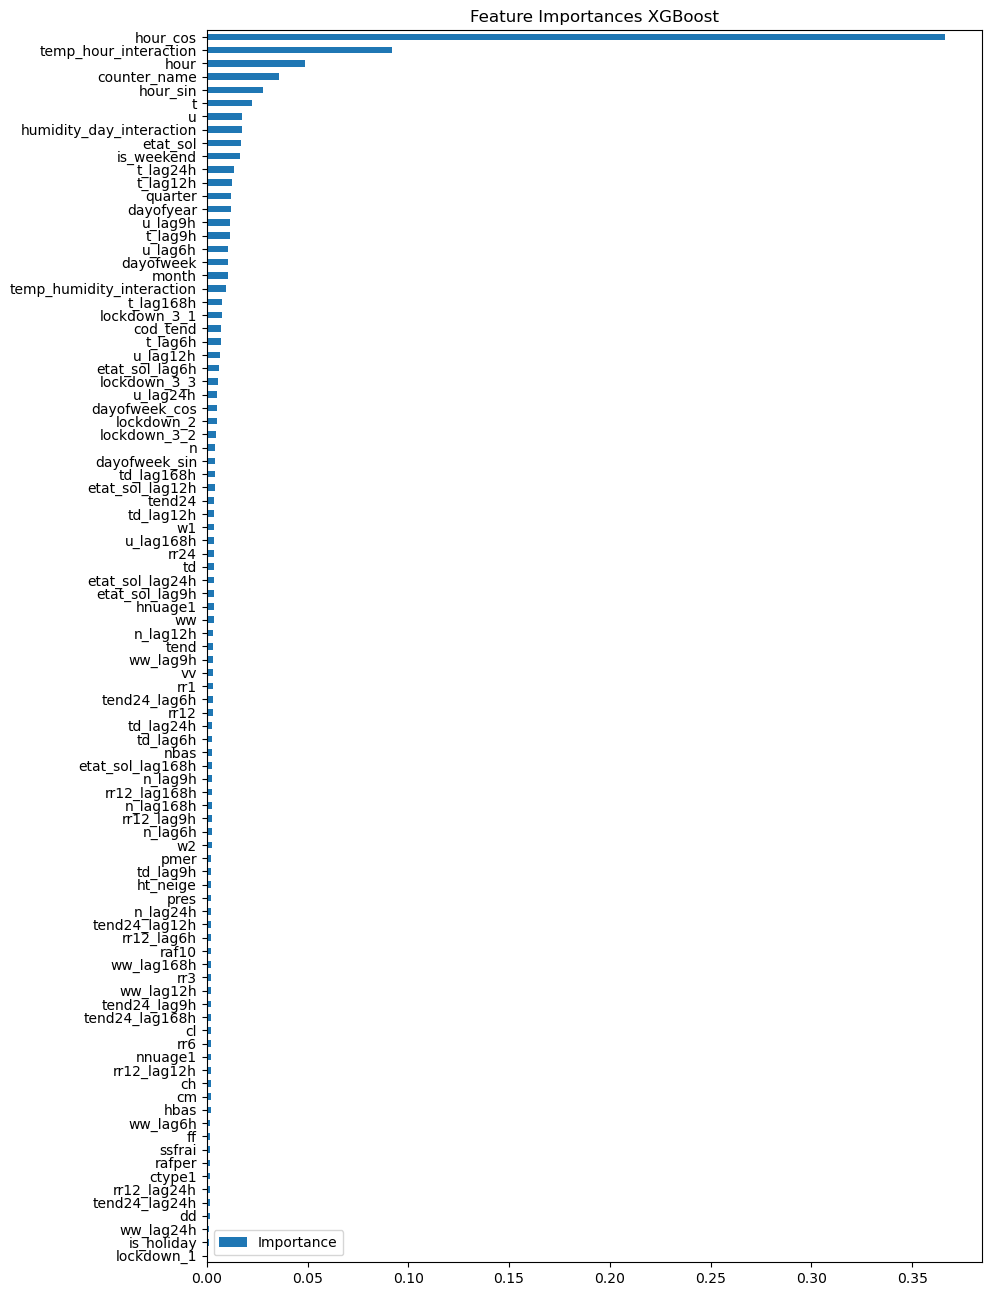

In [130]:
fi = pd.DataFrame(
    data=final_model.feature_importances_,
    index=final_model.feature_names_in_,
    columns=["Importance"],
)

fi.sort_values(by="Importance").plot(
    kind="barh", title="Feature Importances XGBoost", figsize=(10, 16)
)

In [131]:
fi.sort_values(by="Importance", ascending=False)

,Importance
hour_cos,0.366161
temp_hour_interaction,0.092093
hour,0.048751
counter_name,0.035731
hour_sin,0.027828
...,...
tend24_lag24h,0.001729
dd,0.001416
ww_lag24h,0.001276
is_holiday,0.001155


In [132]:
predictions = final_model.predict(X_pred)

In [133]:
predictions

array([0.22095019, 1.6089373 , 1.7767726 , ..., 3.2522023 , 2.0039592 ,
       1.9619765 ], dtype=float32)

In [136]:
fi.to_csv("feature_importances_xgb_weather.csv")

In [137]:
predictions

array([0.22095019, 1.6089373 , 1.7767726 , ..., 3.2522023 , 2.0039592 ,
       1.9619765 ], dtype=float32)

In [138]:
prediction_data.head()

,counter_id,counter_name,site_id,site_name,counter_installation_date,coordinates,counter_technical_id,latitude,longitude
date,,,,,,,,,
2021-09-10 01:00:00,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
2021-09-10 13:00:00,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
2021-09-10 17:00:00,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
2021-09-10 19:00:00,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
2021-09-10 22:00:00,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429


In [29]:
X_train_encoded = pd.get_dummies(X_train, columns=cat_feature)
X_test_encoded = pd.get_dummies(X_test, columns=cat_feature)

In [32]:
model = xgb.XGBRegressor()

In [33]:
tscv = TimeSeriesSplit(n_splits=5)

In [35]:
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=tscv,
    scoring="neg_mean_squared_error",
    verbose=10,
    n_jobs=-1,
)

In [36]:
rfecv.fit(X_train_encoded, y_train)

In [ ]:
optimal_features = X_train_encoded.columns[rfecv.support_]